# Magic cards generation
In this project, we'll use generative adversarial networks to generate new images of magic cards.

# Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [1]:
import warnings as w
w.simplefilter(action = 'ignore', category = FutureWarning)

from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


# Explore the Data

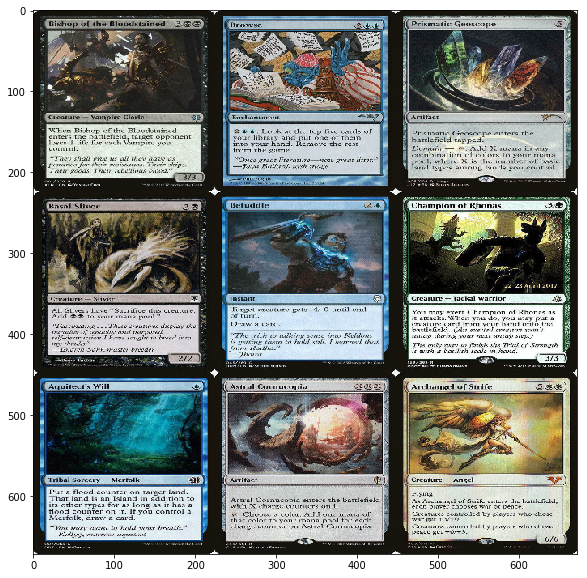

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

import helper
dirpath = '/workspace/data/cards/'

with tf.Session() as sess:
    abatch = sess.run(helper.get_dataset_iterator(dirpath, 9)[0].get_next())
    
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(helper.images_squares_grid(abatch))

# Build the network

## Input

In [3]:
import problem_unittests as tests
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')

    return inputs_real, inputs_z

tests.test_model_inputs(model_inputs)

Tests Passed


## Discriminator

In [4]:
import numpy as np

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Input images
    :param reuse: Define if reuse tensorflow scope
    """
    filters = [64, 128, 256, 512, 256]
    alpha = 0.18
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x = tf.layers.conv2d(images, filters[0], 5, strides=2, padding='same', activation=None, 
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x = tf.maximum(alpha * x, x)
        
        for size in filters[1:]:
            x = tf.layers.conv2d(x, size, 5, strides=2, padding='same', activation=None,
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
            bn = tf.layers.batch_normalization(x, training=True)
            relu = tf.maximum(alpha * bn, bn)
            x = tf.layers.dropout(relu, 0.3)
        
        # Flatten
        flat = tf.reshape(x, (-1, np.prod(relu.shape[1:])))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits

tests.test_discriminator(discriminator, tf)

Tests Passed


## Generator

In [5]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    filters = [1024, 512, 256, 128, 64, 32]
    strides = [2, 2, 2, 2, 1]

    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x = tf.layers.dense(z, 7*7*filters[0])
        # Reshape it to start the convolutional stack
        x = tf.reshape(x, (-1, 7, 7, filters[0]))
        bn = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * bn, bn)
        
        for size, stride in zip(filters[1:], strides):
            noise = tf.random_normal(shape=tf.shape(x), mean=0.0, stddev=0.2, dtype=tf.float32)
            x = x + noise
            x = tf.layers.conv2d_transpose(x, size, 5, strides=stride, padding='same', activation=None,
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
            bn = tf.layers.batch_normalization(x, training=is_train)
            relu = tf.maximum(alpha * bn, bn)
            x = tf.layers.dropout(relu, 0.3)

        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=2, padding='same', activation=None,
                                           kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        out = tf.tanh(logits)
    
    return out


tests.test_generator(generator, tf)

Tests Passed


## Loss

In [6]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smooth1 = tf.random_uniform(tf.shape(d_model_real), minval=0, maxval=0.2)
    smooth0 = tf.random_uniform(tf.shape(d_model_fake), minval=0, maxval=0.2)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=d_logits_real, labels=tf.ones_like(d_model_real) - smooth1))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=d_logits_fake, labels=tf.zeros_like(d_model_fake) + smooth0))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


tests.test_model_loss(model_loss)

Tests Passed


## Optimization

In [7]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


tests.test_model_opt(model_opt, tf)

Tests Passed


# Show output

In [8]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, epoch=''):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.normal(0, 0.5, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})
    
    helper.save_as_image(samples, epoch)
    
    images_grid = helper.images_squares_grid(samples)
    images_grid.save("/workspace/data/visualization/{}_generation_grid.jpeg".format(epoch))

# Train

In [ ]:
def train(epoch_count, z_dim, learning_rate, beta1, dirpath, batch_size):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param dirpath: Path to the dataset
    """
    # Get data
    iterator, data_shape = helper.get_dataset_iterator(dirpath, batch_size, initializable=True)
    next_element = iterator.get_next()
    
    # Build model
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = 3
    input_real, input_z = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Monitor
    print_every = 100
    show_every = 500
    steps = 0
    d_loss_vec = []
    g_loss_vec = []

    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch_i in range(epoch_count):
            sess.run(iterator.initializer)
            while True:
                try:
                    batch_images = sess.run(next_element)
                except tf.errors.OutOfRangeError:
                    break

                batch_images = batch_images * 2.0
                
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                # Losses
                train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                train_loss_g = g_loss.eval({input_z: batch_z})
                
                # Optimize again
                while train_loss_d > 2:
                    _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                
                while train_loss_g > train_loss_d:
                    _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                
                d_loss_vec.append(train_loss_d)
                g_loss_vec.append(train_loss_g)
                
                if steps % print_every == 0:
                    # Print loss
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % show_every == 0:
                    save_path = saver.save(sess, "/workspace/checkpoints/model.ckpt")
                    print("Model saved in path: %s" % save_path)

                    _ = show_generator_output(sess, 4, input_z, image_channels, str(steps))
        save_path = saver.save(sess, "/workspace/checkpoints/model.ckpt")
        _ = show_generator_output(sess, 4, input_z, image_channels, str(steps))

## Run training

In [ ]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3

epochs = 50

with tf.Graph().as_default():
    train(epochs, z_dim, learning_rate, beta1, dirpath, batch_size)

## Using model to generate images

In [9]:
def visu(z_dim, dirpath):
    """
    :param z_dim: Z dimension
    :param dirpath: path of the dataset
    """
    _, data_shape = helper.get_dataset_iterator(dirpath, 1, initializable=True)
    # Build model
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = 3
    input_real, input_z = model_inputs(image_width, image_height, image_channels, z_dim)
    model_loss(input_real, input_z, image_channels)

    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, "/workspace/checkpoints/model.ckpt")
        
        _ = show_generator_output(sess, 9, input_z, image_channels, 'visu')

In [10]:
z_dim = 200


with tf.Graph().as_default():
    visu(z_dim, dirpath)

INFO:tensorflow:Restoring parameters from /workspace/checkpoints/model.ckpt
